In [1]:
# Analysis of Facebook likes using "harmonic" crowdsourcing algorithm.
# This is an analysis performed entirely on the users who have liked both good and bad items; 
# this intersection forms the hardest "core" of the problem.

In [2]:
%matplotlib inline
import json_plus
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import voting
import matplotlib

In [55]:
# Set figure size.
matplotlib.rcParams['figure.figsize'] = (4.0, 2.0)
matplotlib.rcParams['errorbar.capsize'] = 5
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [44]:
# Data loading
with open('likers.json') as data_file:
    data = json.load(data_file)
print("Loaded.")

Loaded.


In [45]:
# Counts
post_list = [i for i in data.keys()]
user_list = []
for i in data.values():
    user_list.extend(i)
user_set = set(user_list)
nlikes = len(user_list)
nuser = len(user_set)
nposts = len(data)
print('N. of posts: %s' % nposts)
print('N. of likes %d' % nlikes)
print('N. of unique users: %s' % nuser)
print('Avg. likes per user: %.2f' % (nlikes/nuser))
print('Avg. likes per post: %.2f' % (nlikes/nposts))

N. of posts: 15500
N. of likes 2376776
N. of unique users: 909236
Avg. likes per user: 2.00
Avg. likes per post: 153.00


In [46]:
# Hoax pages
pages = set([i.split('_')[0] for i in post_list])
# WARNING: commented out pages DO NOT EXIST.
hoax_pages = {'188189217954979',
              '253520844711659',
              '199277020680',
              '233426770069342',
              # '68091825232', 
              # '194120424046954',
              '126393880733870',
              '109383485816534',
              '203737476337348',
              '159590407439801',
              '124489267724876',
              '123944574364433',
              # '130541730433071',
              '278440415537619',
              '101748583911',
              '352513104826417',
              '195235103879949'
              }
nonhoax_pages = pages - hoax_pages
error_pages = hoax_pages - pages
if len(error_pages) > 0:
    print "Error: some hoax pages never appear:", error_pages
print("N. of pages: %d hoax vs. %d non-hoax" % (len(hoax_pages), len(nonhoax_pages)))
print "Hoax pages:", hoax_pages
print "Nonhoax pages:", nonhoax_pages

N. of pages: 14 hoax vs. 18 non-hoax
Hoax pages: set(['126393880733870', '199277020680', '188189217954979', '278440415537619', '203737476337348', '352513104826417', '109383485816534', '101748583911', '253520844711659', '124489267724876', '123944574364433', '159590407439801', '233426770069342', '195235103879949'])
Nonhoax pages: set([u'246240278737917', u'128523133833337', u'230542647135219', u'94897729756', u'492924810790346', u'134760945225', u'32775139194', u'138484279514358', u'365212740272738', u'227175397415634', u'106965734432', u'301266998787', u'389493082245', u'84645527341', u'81631306737', u'129133110517884', u'146489812096483', u'338627506257240'])


In [47]:
# Hoax post categorization
hoax_posts = {x for x in data if x.split('_')[0] in hoax_pages}
print("N. of posts: %d hoax vs. %d non-hoax" % (len(hoax_posts), nposts-len(hoax_posts)))

N. of posts: 8923 hoax vs. 6577 non-hoax


In [48]:
# Computes the number of posts per each page.
posts_per_page = {}
for p, ul in data.items():
    page = p.split('_')[0]
    posts_per_page[page] = posts_per_page.get(page, 0.0) + 1.0
print posts_per_page

{u'32775139194': 1079.0, u'253520844711659': 162.0, u'123944574364433': 36.0, u'301266998787': 61.0, u'233426770069342': 535.0, u'352513104826417': 54.0, u'81631306737': 316.0, u'106965734432': 757.0, u'246240278737917': 37.0, u'188189217954979': 1232.0, u'199277020680': 104.0, u'124489267724876': 771.0, u'146489812096483': 118.0, u'389493082245': 115.0, u'129133110517884': 660.0, u'338627506257240': 3.0, u'230542647135219': 1.0, u'227175397415634': 373.0, u'134760945225': 528.0, u'203737476337348': 176.0, u'365212740272738': 4.0, u'109383485816534': 4003.0, u'101748583911': 1310.0, u'278440415537619': 34.0, u'195235103879949': 86.0, u'159590407439801': 221.0, u'84645527341': 129.0, u'94897729756': 522.0, u'126393880733870': 199.0, u'138484279514358': 443.0, u'128523133833337': 815.0, u'492924810790346': 616.0}


In [49]:
def graph_correct(d):
    """Makes a graph of the correctness as a function of number of likes."""
    print "Accuracy overall:", d['ratio_correct']
    # Now for the graph. 
    ys = d['ratio_correct_likes']
    xs = range(1, 1 + len(ys))
    plt.plot(xs, ys, 'bo')
    plt.xlabel('Number of likes')
    plt.ylabel('Fraction correct')
    plt.ylim(ymax=1.01)
    plt.show()

In [50]:
# Now let's compute the set of users who have voted for BOTH good and bad items. 
hoax_users = set()
nonhoax_users = set()
for p, ul in data.items():
    page = p.split('_')[0]
    # The truth value depends on the page.
    tv = not (page in hoax_pages)
    if tv:
        nonhoax_users.update(ul)
    else:
        hoax_users.update(ul)
users_liked_both = hoax_users & nonhoax_users
print "Number of user who liked both type of pages:", len(users_liked_both)
    

Number of user who liked both type of pages: 14139


In [51]:
# I want to know, how many of the users above have voted for ONLY two pages.
user_cardinality = {}
for p, ul in data.items():
    for u in ul:
        if u in users_liked_both:
            user_cardinality[u] = 1 + user_cardinality.get(u, 0)
num_with_card_2 = 0
for u, c in user_cardinality.items():
    if c == 2:
        num_with_card_2 += 1
print "Number of users in intersection dataset with cardinality 2:", num_with_card_2

Number of users in intersection dataset with cardinality 2: 4532


In [52]:
# Let's compute the set of users who have voted for more than one page.
pages_user = {}
for p, ul in data.items():
    page = p.split('_')[0]
    for u in ul:
        pages_user[u] = pages_user.get(u, set()) | {p}
multi_page_users = set([u for u, ps in pages_user.items() if len(ps) > 1])
print "Numner of users who liked more than one page:", len(multi_page_users)

Numner of users who liked more than one page: 280090


In [53]:
# Run this code AFTER computing the set of hoax users above.
def add_data(g, use_all=False, use_atleast_two=False):
    """Adds the data to a graph g.
    If use_all is True, it uses all data; otherwise it uses data only from the intersection dataset."""
    for p, ul in data.items():
        page = p.split('_')[0]
        # The truth value depends on the page.
        tv = not (page in hoax_pages)
        for u in ul:
            # The polarity is always 1 (pos).
            if use_all or (u in users_liked_both) or (use_atleast_two and u in multi_page_users):
                g.add_edge(u, p, item_true_value=tv)
    print("The graph has been built!")

In [39]:
# Let's get some stats.
reload(voting)
g = voting.VotingGraph()
add_data(g)
g.print_stats()

The graph has been built!
Num items: 10520
Num items with truth known: 10520
Num items with inferred known: 0
Num items testing: 0
Min degree: 1
Num users: 14139
Num likes: 117641


In [40]:
# Let's get some stats.
reload(voting)
g = voting.VotingGraph()
add_data(g, use_all=True)
g.print_stats()

The graph has been built!
Num items: 15500
Num items with truth known: 15500
Num items with inferred known: 0
Num items testing: 0
Min degree: 1
Num users: 909236
Num likes: 2376776


In [46]:
reload(voting)
TESTS = [10, 20, 40, 100, 200, 400, 1000]
results_all_x = []
results_all_y = []
results_all_err = []
g = voting.VotingGraph()
add_data(g, use_all=True)
for f in TESTS[:3]:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_all_x.append(f)
    results_all_y.append(d['ratio_correct'])
    results_all_err.append(d['stdev'])

The graph has been built!
One run result: 0.994838709677
One run result: 0.99476702509
One run result: 0.994910394265
One run result: 0.99476702509
One run result: 0.994623655914
One run result: 0.994838709677
One run result: 0.994695340502
One run result: 0.99476702509
One run result: 0.994623655914
One run result: 0.994551971326
One run result: 0.994838709677
One run result: 0.994623655914
One run result: 0.995125448029
One run result: 0.994623655914
One run result: 0.994551971326
One run result: 0.994910394265
One run result: 0.994982078853
One run result: 0.99476702509
One run result: 0.99476702509
One run result: 0.99476702509
One run result: 0.994838709677
One run result: 0.994623655914
One run result: 0.994910394265
One run result: 0.994336917563
One run result: 0.995125448029
One run result: 0.99476702509
One run result: 0.99476702509
One run result: 0.994623655914
One run result: 0.994838709677
One run result: 0.99476702509
One run result: 0.994982078853
One run result: 0.9949

In [47]:
print results_all_x
print results_all_y
print results_all_err

[10, 10, 10]
[0.9947928315412187, 0.9945765704584041, 0.9944259908687885]
[0.00018177945073084267, 0.0001663545936217604, 0.0001440948332039384]


In [48]:
reload(voting)
TESTS = [10, 20, 40, 100, 200, 400, 1000]
g = voting.VotingGraph()
add_data(g, use_all=True)
for f in TESTS[3:5]:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_all_x.append(f)
    results_all_y.append(d['ratio_correct'])
    results_all_err.append(d['stdev'])

The graph has been built!
One run result: 0.994265232975
One run result: 0.994069729554
One run result: 0.994265232975
One run result: 0.994265232975
One run result: 0.994265232975
One run result: 0.994265232975
One run result: 0.994330400782
One run result: 0.994265232975
One run result: 0.994330400782
One run result: 0.994134897361
One run result: 0.99459107201
One run result: 0.994525904203
One run result: 0.994265232975
One run result: 0.994460736396
One run result: 0.994200065168
One run result: 0.994265232975
One run result: 0.994200065168
One run result: 0.994200065168
One run result: 0.994330400782
One run result: 0.994200065168
One run result: 0.994200065168
One run result: 0.994134897361
One run result: 0.994265232975
One run result: 0.994330400782
One run result: 0.994200065168
One run result: 0.994460736396
One run result: 0.994265232975
One run result: 0.994069729554
One run result: 0.994265232975
One run result: 0.994265232975
One run result: 0.994200065168
One run result

In [49]:
print results_all_x
print results_all_y
print results_all_err

[10, 10, 10, 10, 10]
[0.9947928315412187, 0.9945765704584041, 0.9944259908687885, 0.9942717497556207, 0.9941477014847955]
[0.00018177945073084267, 0.0001663545936217604, 0.0001440948332039384, 9.8616786904011806e-05, 8.3849643572967626e-05]


In [50]:
reload(voting)
TESTS = [10, 20, 40, 100, 200, 400, 1000]
g = voting.VotingGraph()
add_data(g, use_all=True)
for f in TESTS[5:]:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_all_x.append(f)
    results_all_y.append(d['ratio_correct'])
    results_all_err.append(d['stdev'])


The graph has been built!
One run result: 0.84413400595
One run result: 0.994049928858
One run result: 0.894127538481
One run result: 0.9924330617
One run result: 0.992885784504
One run result: 0.993985254172
One run result: 0.871944121071
One run result: 0.992756435131
One run result: 0.994049928858
One run result: 0.993532531367
One run result: 0.993985254172
One run result: 0.808886301901
One run result: 0.758375371879
One run result: 0.977751907903
One run result: 0.761673780882
One run result: 0.994179278231
One run result: 0.994049928858
One run result: 0.880933902471
One run result: 0.993726555426
One run result: 0.993985254172
One run result: 0.888436166085
One run result: 0.895485706894
One run result: 0.893028068814
One run result: 0.725973354029
One run result: 0.990622170482
One run result: 0.994049928858
One run result: 0.986353641185
One run result: 0.99295045919
One run result: 0.994114603544
One run result: 0.993985254172
One run result: 0.989328676756
One run result: 0

In [51]:
print results_all_x
print results_all_y
print results_all_err

[10, 10, 10, 10, 10, 10, 10]
[0.9947928315412187, 0.9945765704584041, 0.9944259908687885, 0.9942717497556207, 0.9941477014847955, 0.9369124304747122, 0.7925489183080401]
[0.00018177945073084267, 0.0001663545936217604, 0.0001440948332039384, 9.8616786904011806e-05, 8.3849643572967626e-05, 0.081584186225229241, 0.15831802229801958]


In [54]:
# Now for the intersection dataset.
reload(voting)
results_intersection_x = []
results_intersection_y = []
results_intersection_err = []
TESTS = [10, 20, 40, 100, 200, 400, 1000]
g = voting.VotingGraph()
add_data(g, use_all=False)
for f in TESTS[:4]:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_intersection_x.append(f)
    results_intersection_y.append(d['ratio_correct'])
    results_intersection_err.append(d['stdev'])

The graph has been built!
One run result: 0.86934938741
One run result: 0.901774397972
One run result: 0.913603717786
One run result: 0.906104773975
One run result: 0.895648500211
One run result: 0.895648500211
One run result: 0.883502323616
One run result: 0.905682298268
One run result: 0.886987748204
One run result: 0.869666244191
One run result: 0.903992395437
One run result: 0.892585551331
One run result: 0.903464300803
One run result: 0.892374313477
One run result: 0.915293620617
One run result: 0.879171947613
One run result: 0.888677651035
One run result: 0.882657372201
One run result: 0.882551753274
One run result: 0.895437262357
One run result: 0.922581326574
One run result: 0.895437262357
One run result: 0.898394592311
One run result: 0.919201520913
One run result: 0.912230671736
One run result: 0.903992395437
One run result: 0.909167722856
One run result: 0.889945078158
One run result: 0.889839459231
One run result: 0.907372201098
One run result: 0.876848331221
One run result

In [55]:
# Now for the intersection dataset.
reload(voting)
TESTS = [10, 20, 40, 100, 200, 400, 1000]
g = voting.VotingGraph()
add_data(g, use_all=False)
for f in TESTS[4:]:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_intersection_x.append(f)
    results_intersection_y.append(d['ratio_correct'])
    results_intersection_err.append(d['stdev'])

The graph has been built!
One run result: 0.883358807795
One run result: 0.504107756974
One run result: 0.55206343141
One run result: 0.767386320214
One run result: 0.634123041651
One run result: 0.491497898357
One run result: 0.848204050439
One run result: 0.870557890715
One run result: 0.554642720673
One run result: 0.444306457776
One run result: 0.690676346962
One run result: 0.817921283913
One run result: 0.833779136416
One run result: 0.70137562094
One run result: 0.809323653038
One run result: 0.555215896064
One run result: 0.668035918991
One run result: 0.847917462744
One run result: 0.636988918609
One run result: 0.5550248376
One run result: 0.672239205197
One run result: 0.648643484906
One run result: 0.849732518151
One run result: 0.556075659152
One run result: 0.871513183034
One run result: 0.47544898739
One run result: 0.819163163928
One run result: 0.623423767673
One run result: 0.842185708827
One run result: 0.779709591135
One run result: 0.653802063431
One run result: 0.

In [56]:
print results_intersection_x
print results_intersection_y
print results_intersection_err

[10, 20, 40, 100, 200, 400, 1000]
[0.8981516687790452, 0.8505363217930758, 0.8258925611777322, 0.744059529524724, 0.6773977837218189, 0.5783037926434152, 0.519162702188392]
[0.015822423827105362, 0.038183501343605319, 0.06444397351136516, 0.10609695794657316, 0.13381654475491597, 0.12521980663556254, 0.1100818925571475]


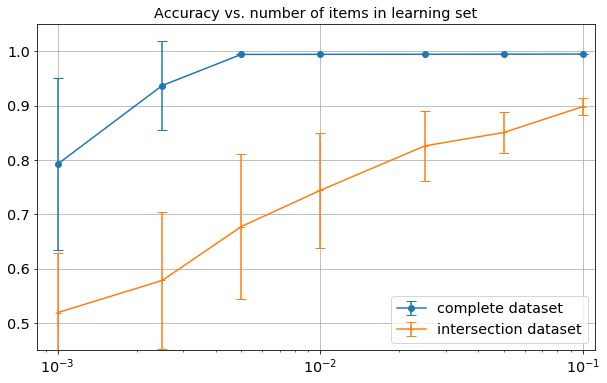

In [4]:
# Let's generate the graphs, without having to re-run everything.
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
# res_all_x = results_all_x
# res_all_y = results_all_y
# res_all_err = results_all_err
# res_int_x = results_intersection_x
# res_int_y = results_intersection_y
# res_int_err = results_intersection_err
res_all_x = [10, 20, 40, 100, 200, 400, 1000]
res_all_y = [0.9947928315412187, 0.9945765704584041, 0.9944259908687885, 0.9942717497556207, 0.9941477014847955, 0.9369124304747122, 0.7925489183080401]
res_all_err = [0.00018177945073084267, 0.0001663545936217604, 0.0001440948332039384, 9.8616786904011806e-05, 8.3849643572967626e-05, 0.081584186225229241, 0.15831802229801958]
res_int_x = [10, 20, 40, 100, 200, 400, 1000]
res_int_y = [0.8981516687790452, 0.8505363217930758, 0.8258925611777322, 0.744059529524724, 0.6773977837218189, 0.5783037926434152, 0.519162702188392]
res_int_err = [0.015822423827105362, 0.038183501343605319, 0.06444397351136516, 0.10609695794657316, 0.13381654475491597, 0.12521980663556254, 0.1100818925571475]

# res_gt2_x = [10, 20, 50, 100, 200, 400, 1000]
# res_gt2_y = [0.9973278594065111, 0.9970522006141249, 0.9968679719539622, 0.9968190151911995, 0.9925245944361196, 0.9633779568494931, 0.8052144572058919]
# res_gt2_err = [0.00014918118105160575, 0.00017208488861027103, 9.1833862792139789e-05, 8.3946414408233029e-05, 0.020896853639959776, 0.065442264421548352, 0.16442557191302057]

# We need the fractions
res_a_x = [1.0 / x for x in res_all_x]
res_i_x = [1.0 / x for x in res_int_x]
# res_a_x = [x * nposts for x in res_a_x]
# Builds the plots.
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='complete dataset')
# ax.errorbar(res_a_x, res_gt2_y, yerr=res_gt2_err, marker='x', label='multipage dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='+', label='intersection dataset')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
ax.grid()
plt.title('Accuracy vs. number of items in learning set')
plt.plot()
plt.savefig('accuracy_vs_perc.pdf')

In [5]:
# Let's define the results from the other notebook on logistic regression.
# See ../logistic_regression/logreg_tests_final.ipynb 
logi_res_all_y = [0.96669677419354827, 0.95533989813242781, 0.93099144173798531, 0.90329749103942636, 0.84348699993516163, 0.74553227266847766, 0.63488149822408779]
logi_res_all_err = [0.0055568473928726322, 0.0096648261910718368, 0.019235373404428768, 0.038534806597708672, 0.059711620024988706, 0.086215312070645644, 0.11551090232666143]
logi_res_int_y = [0.91654203633291076, 0.89193315989593758, 0.84144907856450035, 0.77512049927988469, 0.70986052732136029, 0.63810367829235748, 0.56102949571836336]
logi_res_int_err = [0.0077756103084875598, 0.013865324498876704, 0.029058334540871818, 0.047490066556372029, 0.05720552897645028, 0.060875349450386827, 0.054692571945068366]


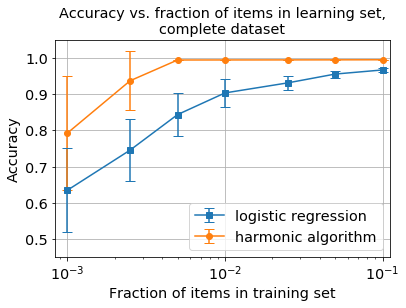

In [38]:
# Let us now plot the results, on the same dataset, of logistic and harmonic.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
ax.grid()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. fraction of items in learning set,\ncomplete dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_all_s.pdf', bbox_inches='tight')

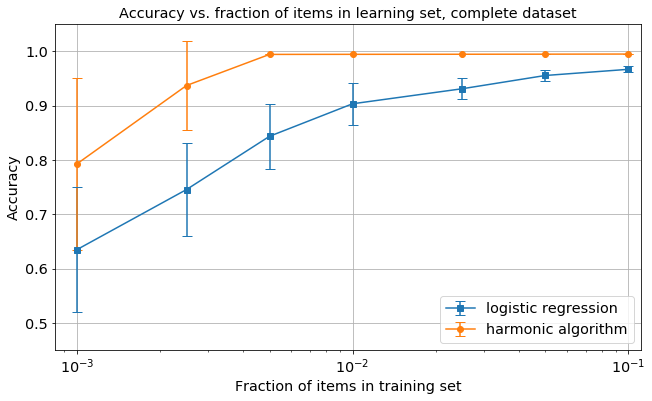

In [42]:
# Let us now plot the results, on the same dataset, of logistic and harmonic.
fig, ax = plt.subplots(figsize=(10.5, 6))
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
ax.grid()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. fraction of items in learning set, complete dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_all_b.pdf', bbox_inches='tight')

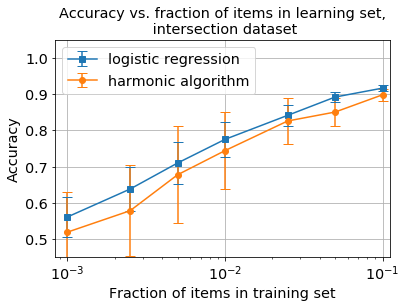

In [37]:
# Now the same, but for the intersection dataset.
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
ax.grid()
plt.title('Accuracy vs. fraction of items in learning set,\n intersection dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_int_s.pdf', bbox_inches='tight')

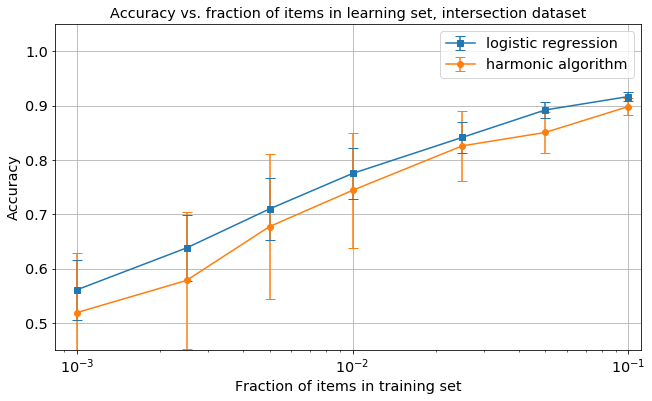

In [43]:
# Now the same, but for the intersection dataset.
fig, ax = plt.subplots(figsize=(10.5, 6))
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
ax.grid()
plt.title('Accuracy vs. fraction of items in learning set, intersection dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_int_b.pdf', bbox_inches='tight')

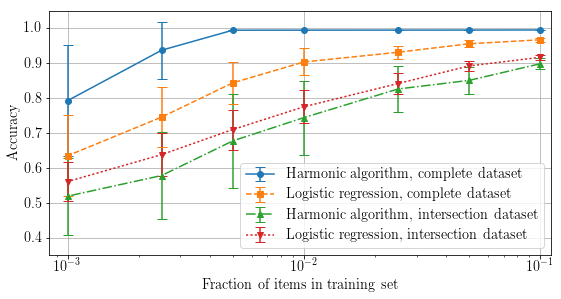

In [65]:
# We can also produce all four in the same graph, in case we lack space.
fig, ax = plt.subplots(figsize=(9,4.5))
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='Harmonic algorithm, complete dataset')
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', ls='--', label='Logistic regression, complete dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='^', ls='-.', label='Harmonic algorithm, intersection dataset')
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='v', ls=':', label='Logistic regression, intersection dataset')
plt.ylim(0.35, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
ax.legend()
ax.grid()
plt.plot()
plt.savefig('accuracy_vs_fraction_joint.pdf', bbox_inches='tight')

In [71]:
# Now we do the same as above, BUT resampling so that we sample each item
# with probability proportional to the number of likes.
reload(voting)
TESTS = [(10, 50), (20, 50), (50, 50), (100, 50), (200, 50), (400, 50), (1000, 50)]
results_all_edges_x = []
results_all_edges_y = []
results_all_edges_err = []
g = voting.VotingGraph()
add_data(g, use_all=True)
for num_chunks, num_eval_chunks in TESTS:
    cs = []
    for i in range(num_eval_chunks):
        cs.append(g.evaluate_inference_selecting_prop_likes(1.0 / num_chunks))
    results_all_edges_x.append(num_chunks)
    results_all_edges_y.append(np.average(cs))
    results_all_edges_err.append(np.std(cs))
    print "Results:", results_all_edges_x, results_all_edges_y, results_all_edges_err
        

The graph has been built!
Results: [10] [0.88999788762146181] [0.0068357969684385966]
Results: [10, 20] [0.88999788762146181, 0.87536521913147891] [0.0068357969684385966, 0.0084777131391844795]
Results: [10, 20, 50] [0.88999788762146181, 0.87536521913147891, 0.82294277400581961] [0.0068357969684385966, 0.0084777131391844795, 0.037350044990327166]
Results: [10, 20, 50, 100] [0.88999788762146181, 0.87536521913147891, 0.82294277400581961, 0.72839750360057598] [0.0068357969684385966, 0.0084777131391844795, 0.037350044990327166, 0.085970631359878633]
Results: [10, 20, 50, 100, 200] [0.88999788762146181, 0.87536521913147891, 0.82294277400581961, 0.72839750360057598, 0.67358937613451797] [0.0068357969684385966, 0.0084777131391844795, 0.037350044990327166, 0.085970631359878633, 0.09539911360266122]
Results: [10, 20, 50, 100, 200, 400] [0.88999788762146181, 0.87536521913147891, 0.82294277400581961, 0.72839750360057598, 0.67358937613451797, 0.63884981894415849] [0.0068357969684385966, 0.00847771

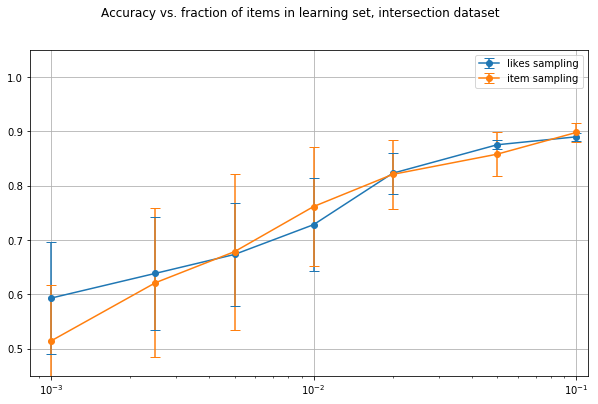

In [29]:
# Now for a comparison graph.
res_int_x = [10, 20, 50, 100, 200, 400, 1000]
res_int_y = [0.897950992817913, 0.8580698419051431, 0.8208923375363725, 0.7617321171387422, 0.6787648070309514, 0.6216285496474175, 0.5144928639391056]
res_int_err = [0.016882041525877665, 0.039889350640687743, 0.063391675604248701, 0.10959444258799378, 0.14373167394339534, 0.13662163819741741, 0.10275693241854568]
res_edg_x = [10, 20, 50, 100, 200, 400, 1000]
res_edg_y = [0.88999788762146181, 0.87536521913147891, 0.82294277400581961, 0.72839750360057598, 0.67358937613451797, 0.63884981894415849, 0.59327719097916076]
res_edg_err = [0.0068357969684385966, 0.0084777131391844795, 0.037350044990327166, 0.085970631359878633, 0.09539911360266122, 0.10455997072894992, 0.10284262914317449]
# We need the fractions
res_e_x = [1.0 / x for x in res_edg_x]
res_i_x = [1.0 / x for x in res_int_x]
# Builds the plots.
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_edg_y, yerr=res_edg_err, marker='o', label='likes sampling')
ax.errorbar(res_i_x, res_int_y, yerr=res_int_err, marker='o', label='item sampling')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
ax.grid()
fig.suptitle('Accuracy vs. fraction of items in learning set, intersection dataset')
plt.plot()
plt.savefig('accuracy_like_sampling.pdf')

In [54]:
# First, we do the analysis of leave-one-page-out. 
reload(voting)
frac_correct_all = [] # On complete graph
frac_correct_w = []
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=True)
for pg in pages:
    print "page:", pg
    # Creates the function that classifies items.
    def is_learning(itid):
        return itid.split('_')[0] != pg
    fc = g.evaluate_inference_given_learning(is_learning)
    print "For all, correctness:", fc
    frac_correct_all.append(fc)
    frac_correct_w.append(posts_per_page[pg])
print "Final average correctness for leave-one-page-out all:", np.average(frac_correct_all)
print "Standard deviation:", np.std(frac_correct_all)


The graph has been built!
page: 32775139194
For all, correctness: 1.0
page: 253520844711659
For all, correctness: 1.0
page: 123944574364433
For all, correctness: 0.972222222222
page: 301266998787
For all, correctness: 1.0
page: 233426770069342
For all, correctness: 0.998130841121
page: 352513104826417
For all, correctness: 1.0
page: 81631306737
For all, correctness: 1.0
page: 106965734432
For all, correctness: 1.0
page: 246240278737917
For all, correctness: 1.0
page: 188189217954979
For all, correctness: 1.0
page: 199277020680
For all, correctness: 1.0
page: 124489267724876
For all, correctness: 0.972762645914
page: 146489812096483
For all, correctness: 1.0
page: 389493082245
For all, correctness: 1.0
page: 129133110517884
For all, correctness: 0.995454545455
page: 338627506257240
For all, correctness: 1.0
page: 230542647135219
For all, correctness: 1.0
page: 227175397415634
For all, correctness: 1.0
page: 134760945225
For all, correctness: 1.0
page: 203737476337348
For all, correctnes

In [51]:
# We do the analysis of leave-one-page-out, also for the intersection dataset.
reload(voting)
frac_correct_all = [] # On complete graph
frac_correct_w = []
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=False)
for pg in pages:
    print "page:", pg
    # Creates the function that classifies items.
    def is_learning(itid):
        return itid.split('_')[0] != pg
    fc = g.evaluate_inference_given_learning(is_learning)
    print "For all, correctness:", fc
    frac_correct_int.append(fc)
    frac_correct_w.append(posts_per_page[pg])
print "Final average correctness for leave-one-page-out intersection:", np.average(frac_correct_int, weights=frac_correct_w)


The graph has been built!
page: 32775139194
For all, correctness: 0.948035487959
page: 253520844711659
For all, correctness: 0.814285714286
page: 123944574364433
For all, correctness: 1
page: 301266998787
For all, correctness: 0.0
page: 233426770069342
For all, correctness: 0.443298969072
page: 352513104826417
For all, correctness: 0.538461538462
page: 81631306737
For all, correctness: 0.0
page: 106965734432
For all, correctness: 0.87134502924
page: 246240278737917
For all, correctness: 0.972972972973
page: 188189217954979
For all, correctness: 0.728194726166
page: 199277020680
For all, correctness: 0.77380952381
page: 124489267724876
For all, correctness: 0.545454545455
page: 146489812096483
For all, correctness: 0.131578947368
page: 389493082245
For all, correctness: 0.41095890411
page: 129133110517884
For all, correctness: 0.724050632911
page: 338627506257240
For all, correctness: 0.333333333333
page: 230542647135219
For all, correctness: 1
page: 227175397415634
For all, correctness

In [66]:
# Now, let's try to keep HALF of the pages out. 
# Now, we do the analysis in which we randomly select two 
# pages hoax and two non-hoax, and we learn from those alone.
reload(voting)
frac_correct_all_half = [] # On complete graph
weights_correct_all_half = []
fraction_pages = 0.5
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=True)
num_hoax_in = max(1, int(0.5 + len(hoax_pages) * fraction_pages))
num_nonhoax_in = max(1, int(0.5 + len(nonhoax_pages) * fraction_pages))
hoax_pages_l = list(hoax_pages)
nonhoax_pages_l = list(nonhoax_pages)
for _ in range(50):
    # Picks pages in and out.
    random.shuffle(hoax_pages_l)
    random.shuffle(nonhoax_pages_l)
    learn_pages = hoax_pages_l[:num_hoax_in] + nonhoax_pages_l[:num_nonhoax_in]
    test_pages = hoax_pages_l[num_hoax_in:] + nonhoax_pages_l[num_nonhoax_in:]
    # Computes the weight of the run.
    num_learn_posts = np.sum([posts_per_page[p] for p in learn_pages])
    num_test_posts = np.sum([posts_per_page[p] for p in test_pages])
    w = num_learn_posts * num_test_posts
    print "N learn", num_learn_posts, "N test", num_test_posts, "w", w
    # Defines the function.
    def is_learning(itid):
        return itid.split('_')[0] in learn_pages
    fc = g.evaluate_inference_given_learning(is_learning)
    print "Learning from 2 of each kind, all:", fc
    frac_correct_all_half.append(fc)
    weights_correct_all_half.append(w)

print "Final average correctness for learning from half of each kind, all:", np.average(frac_correct_all_half, weights=weights_correct_all_half)
print "avg", np.average(frac_correct_all_half)
print "stdev", np.std(frac_correct_all_half)



The graph has been built!
N learn 9719.0 N test 5781.0 w 56185539.0
Learning from 2 of each kind, all: 0.992042899152
N learn 4569.0 N test 10931.0 w 49943739.0
Learning from 2 of each kind, all: 0.994602506633
N learn 8684.0 N test 6816.0 w 59190144.0
Learning from 2 of each kind, all: 0.993838028169
N learn 9791.0 N test 5709.0 w 55896819.0
Learning from 2 of each kind, all: 0.99316868103
N learn 10411.0 N test 5089.0 w 52981579.0
Learning from 2 of each kind, all: 0.99135390057
N learn 4443.0 N test 11057.0 w 49126251.0
Learning from 2 of each kind, all: 0.995749299087
N learn 9857.0 N test 5643.0 w 55623051.0
Learning from 2 of each kind, all: 0.994329257487
N learn 9414.0 N test 6086.0 w 57293604.0
Learning from 2 of each kind, all: 0.990469930989
N learn 9896.0 N test 5604.0 w 55457184.0
Learning from 2 of each kind, all: 0.990720913633
N learn 7974.0 N test 7526.0 w 60012324.0
Learning from 2 of each kind, all: 0.995083709806
N learn 11133.0 N test 4367.0 w 48617811.0
Learning f

In [69]:
# Now, let's try to keep HALF of the pages out. 
# Now, we do the analysis in which we randomly select two 
# pages hoax and two non-hoax, and we learn from those alone.
reload(voting)
frac_correct_int_half = [] # On complete graph
weights_correct_int_half = []
fraction_pages = 0.5
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=False)
num_hoax_in = max(1, int(0.5 + len(hoax_pages) * fraction_pages))
num_nonhoax_in = max(1, int(0.5 + len(nonhoax_pages) * fraction_pages))
hoax_pages_l = list(hoax_pages)
nonhoax_pages_l = list(nonhoax_pages)
for _ in range(50):
    # Picks pages in and out.
    random.shuffle(hoax_pages_l)
    random.shuffle(nonhoax_pages_l)
    learn_pages = hoax_pages_l[:num_hoax_in] + nonhoax_pages_l[:num_nonhoax_in]
    test_pages = hoax_pages_l[num_hoax_in:] + nonhoax_pages_l[num_nonhoax_in:]
    # Computes the weight of the run.
    num_learn_posts = np.sum([posts_per_page[p] for p in learn_pages])
    num_test_posts = np.sum([posts_per_page[p] for p in test_pages])
    w = num_learn_posts * num_test_posts
    print "N learn", num_learn_posts, "N test", num_test_posts, "w", w
    # Defines the function.
    def is_learning(itid):
        return itid.split('_')[0] in learn_pages
    fc = g.evaluate_inference_given_learning(is_learning)
    print "Learning from half of each kind, all:", fc
    frac_correct_int_half.append(fc)
    weights_correct_int_half.append(w)
print "Final average correctness for learning from half of each kind, intersection:", np.average(frac_correct_int_half, weights=weights_correct_int_half)
print "avg", np.average(frac_correct_int_half)
print "stdev", np.std(frac_correct_int_half)


The graph has been built!
N learn 4012.0 N test 11488.0 w 46089856.0
Learning from half of each kind, all: 0.33834398096
N learn 10527.0 N test 4973.0 w 52350771.0
Learning from half of each kind, all: 0.512114866886
N learn 6822.0 N test 8678.0 w 59201316.0
Learning from half of each kind, all: 0.290128755365
N learn 7406.0 N test 8094.0 w 59944164.0
Learning from half of each kind, all: 0.473149775434
N learn 11021.0 N test 4479.0 w 49363059.0
Learning from half of each kind, all: 0.562363238512
N learn 8391.0 N test 7109.0 w 59651619.0
Learning from half of each kind, all: 0.459480418767
N learn 7272.0 N test 8228.0 w 59834016.0
Learning from half of each kind, all: 0.661280788177
N learn 5934.0 N test 9566.0 w 56764644.0
Learning from half of each kind, all: 0.349534342258
N learn 9162.0 N test 6338.0 w 58068756.0
Learning from half of each kind, all: 0.588150979455
N learn 6337.0 N test 9163.0 w 58065931.0
Learning from half of each kind, all: 0.73710534542
N learn 7188.0 N test 8